# Loan Prediction Project

This dataset is a from a competition on the data science website AnalyticsVidhya. The goal of my project, however is not to achieve the highest ranking on the competition as I possibly can, but rather to treat this as a real business case. Specifically, I will be doing preliminary analysis via EDA, experimenting with feature engineering, selecting the best models through cross-validation, tuning the models to their best capabilities via hyperparameter tuning, optimizing the model for the business case via threshold optimization, and finally convincing model adoption to the stakeholders through model interpretation and presenting uncertainties.

The model I constructed through this project ended up in the top 10% of the leaderboard for this competition. The competition amongst top 10% is fierce; even a mere 1% increase from my submitted test accuracy score will jump my ranking to the top 1%, and another 1% increase will get me to the top 0.01%. However, this fact also deems the competition rankings as trivial; the stochastic nature of the models used (both in terms of the algorithm of the machine learning model and the hyperparameter tuning via Randomized Search) can influence the model accuracy by a few percentage points without changing any other processes. Therefore, the difference between top 10% and top 0.01% may be boiled down to luck. Although methodologies would have to be significantly improved to get competition ranking to top 10 rank, and that is certainly an area that I could spend the time to refine, I think there is a diminishing return with respect to effort. Hence, I chose to instead focus on how I can influence hypothetical stakeholders with my project.

<br>
To give a background information of the problem at hand, for this project I am a data scientist at Dream Housing Finance Company, a company specialized in offering loans to applicants looking to buy homes in urban, semiurban, and rural areas. Traditionally, the company had domain experts review each application, and determine whether the applicant shall be accepted or declined a loan. The company is trying to see whether they can automate this human proccess via machine learning. 
<br>
<br>
Let's start by loading and exploring the data.

# Part One: Data Loading and EDA

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from numpy import mean

In [675]:
# Importing the training dataset
train = pd.read_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Loan Prediction Project\train_ctrUa4K.csv")

In [5]:
# Preliminary research of the data
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train.shape

(614, 13)

The training data only consists of 614 rows. In order to use our small training set efficiently, I will be using k-fold cross-validation over splitting this training set into training and validation sets. One thing I must note is that by choosing this method, I will be using the full training data for the EDA, and thus any modeling descisions I make from the EDA cannot be validated using the validation set that was held out during EDA.

In [8]:
# Find types of the columns and the missing value numbers. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


There are 7 columns with missing values

In [3]:
# Find the percentage of missing values per column

def find_null_perc(df):
    cols = list(df.columns)
    for col in cols:
        null_counts = df[col].isnull().sum()
        if null_counts > 0:
            perc_null = null_counts/df.shape[0]            # Finding percentage of null of the column by dividing by the number of rows
            perc_null = str(round(perc_null*100,2))+"%"    # Converting the missing percentage into a readable format
            print(f"The column {col} had {null_counts} missing values, and therefore {perc_null} of the values are missing")

In [18]:
find_null_perc(train)

The column Gender had 13 missing values, and therefore 2.12% of the values are missing
The column Married had 3 missing values, and therefore 0.49% of the values are missing
The column Dependents had 15 missing values, and therefore 2.44% of the values are missing
The column Self_Employed had 32 missing values, and therefore 5.21% of the values are missing
The column LoanAmount had 22 missing values, and therefore 3.58% of the values are missing
The column Loan_Amount_Term had 14 missing values, and therefore 2.28% of the values are missing
The column Credit_History had 50 missing values, and therefore 8.14% of the values are missing


None of the columns are missing too many values, and thus non warrant a full dropping of the column. Now, we are faced with a situation in which we can 
<br>
<br>
1. Drop the rows with the missing values. Though this seems like the easiest at first glance, it also may be detrimental to the model's performance, since there are not many rows to begin with. Dropping 50 rows to accomodate for Credit_History column alone will result in discarding about 8% of the entire dataset. <br>
2. Impute using central tendencies, such as mean or median (mode for categorical variables). Though this is a common approach, it may not make much sense to impute features such as Gender or Married just by using average values.
3. Impute using classification outputs of machine learning. This may be the most robust approach that is also computationally feasible only because of the small dataset.


We can decide our imputation strategy after our EDA.

In [676]:
# Taking out the loan ID column as it offers no benefit to model prediction
train.drop(columns = ["Loan_ID"], inplace = True)

I shall start the EDA with the label column.

In [10]:
train.Loan_Status.value_counts(normalize = True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

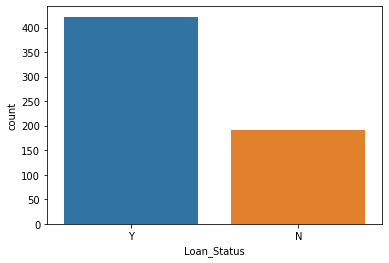

In [11]:
sns.countplot(train.Loan_Status)

There is a sign of class imbalance for our target variable. About 70% of the applicants have gotten their loans approved, while only 30% have gotten their loans declined. This class imbalance needs to be taken into account on downstream modeling. In order for our models to train on sufficient numbers of the rarer class, I will use stratified k-fold cross validation.

Gender Column

In [34]:
train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [35]:
train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [674]:
# Helper function for EDA
def count_statistic(column_name, normalize = True):
    if normalize == True:
        print("Univariate value counts")
        print(train[column_name].value_counts(normalize = True))
        print("\n")
        print("Multivariate value counts w/ label data")
        print(train.groupby(column_name).Loan_Status.value_counts(normalize = True))
    else:
        print("Univariate value counts")
        print(train[column_name].value_counts())
        print("\n")
        print("Multivariate value counts w/ label data")
        print(train.groupby(column_name).Loan_Status.value_counts())
    
    plt.figure(figsize = (6,5))
    sns.countplot(train[column_name], hue = train.Loan_Status)
    plt.plot()


Univariate value counts
Male      0.813644
Female    0.186356
Name: Gender, dtype: float64


Multivariate value counts w/ label data
Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64


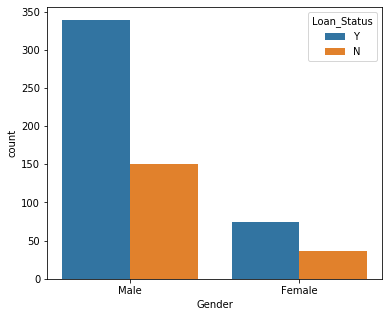

In [677]:
# There are many more males than females in this dataset
count_statistic("Gender")

It seems that the proportion of loan status between male and female are similar.

<br>Married Column

Univariate value counts
Yes    0.651391
No     0.348609
Name: Married, dtype: float64


Multivariate value counts w/ label data
Married  Loan_Status
No       Y              0.629108
         N              0.370892
Yes      Y              0.716080
         N              0.283920
Name: Loan_Status, dtype: float64


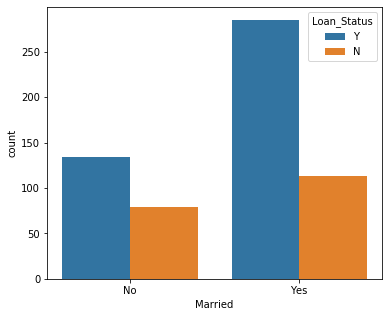

In [678]:
count_statistic("Married")

About 66% of the applicants are married, which is something to take note of when making imputation decisions.

It seems that people that are married seem to get loans, although the relationship is obvious not causal.

In [67]:
train.groupby(["Married", "Gender"]).Loan_Status.value_counts(normalize = True)

Married  Gender  Loan_Status
No       Female  Y              0.637500
                 N              0.362500
         Male    Y              0.623077
                 N              0.376923
Yes      Female  Y              0.741935
                 N              0.258065
         Male    Y              0.717087
                 N              0.282913
Name: Loan_Status, dtype: float64

Interesting finding: for both married and unmarried cases, females have a very slightly higher percentage of loans accepted than males, but when marriage is not considered, males have a higher percentage of loans accepted.

In [68]:
train.groupby("Married").Gender.value_counts(normalize = True)

Married  Gender
No       Male      0.619048
         Female    0.380952
Yes      Male      0.920103
         Female    0.079897
Name: Gender, dtype: float64

Dependents Column

Univariate value counts
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64


Multivariate value counts w/ label data
Dependents  Loan_Status
0           Y              0.689855
            N              0.310145
1           Y              0.647059
            N              0.352941
2           Y              0.752475
            N              0.247525
3+          Y              0.647059
            N              0.352941
Name: Loan_Status, dtype: float64


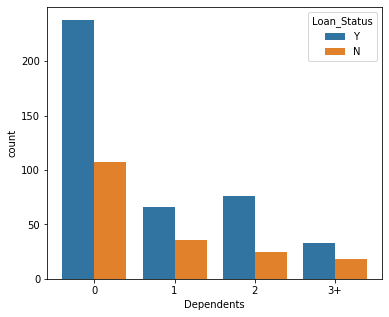

In [679]:
count_statistic("Dependents")

From the graph above, it seems that having 2 dependents result in higher chance of getting the loan accepted. The multivariate value counts confirm this idea.

With the value_counts output we now know that the Dependents column is a categorical column. The column cannot be ordinally encoded, as the scale of difference between 2 and 3+ is not the same as between 0 and 1 or 1 and 2.

In [185]:
# Converting the column to a categorical one
train["Dependents"] = train["Dependents"].astype(np.object)

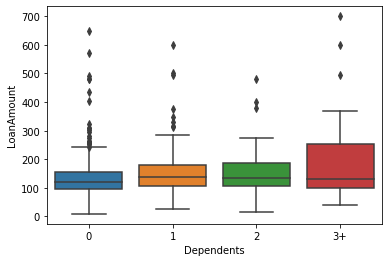

In [84]:
# Investigating whether higher number of dependents are associated with higher loan amounts
sns.boxplot(train.Dependents, train.LoanAmount)

As expected, the loan amount increases with dependents, although there is a slight decrease in loan amount between 1 and 2 dependents. This can potentially be due to some outliers.

<br>Education Column

Univariate value counts
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64


Multivariate value counts w/ label data
Education     Loan_Status
Graduate      Y              0.708333
              N              0.291667
Not Graduate  Y              0.611940
              N              0.388060
Name: Loan_Status, dtype: float64


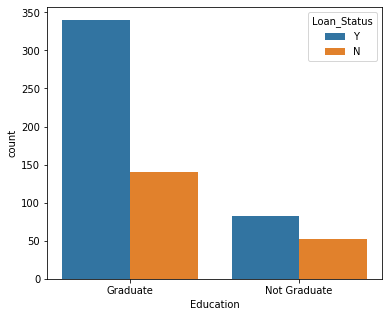

In [680]:
count_statistic("Education")

Seeing the difference in proportion of accepted loans between graduate vs non-graduates, we may be able to infer that education status may be a signal for this classification.

<br> Self Employed & Applicant Income Column

Univariate value counts
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64


Multivariate value counts w/ label data
Self_Employed  Loan_Status
No             Y              0.686000
               N              0.314000
Yes            Y              0.682927
               N              0.317073
Name: Loan_Status, dtype: float64


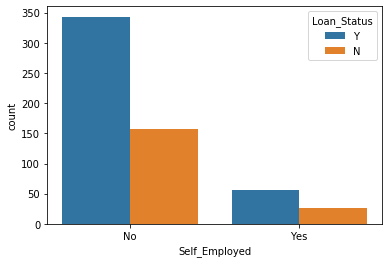

In [96]:
count_statistic("Self_Employed")

This column had the second largest number of missing values. Around 86% of the applicants are not self-employed, which should be noted when making imputing decisions. Contrary to my naive belief, being self-employed or not seem to not have an effect on loan status.

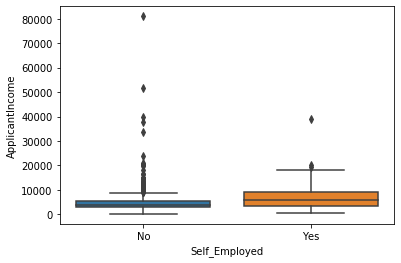

In [99]:
# Seeing if self-employed people make different average income than the others
sns.boxplot(x = train.Self_Employed, y = train.ApplicantIncome)

There seems to be many outliers for the "No" class for Self_Employed. We can perhaps tinker around with omission of outliers to see if that will increase generalization capabilities of the model.

In [103]:
train[train["Self_Employed"] == "No"].ApplicantIncome.median()

3705.5

In [104]:
train[train["Self_Employed"] == "Yes"].ApplicantIncome.median()

5809.0

Self employed applicants have a much higher median income than applicants with employers. Let's see how applicant income can affect loan status.

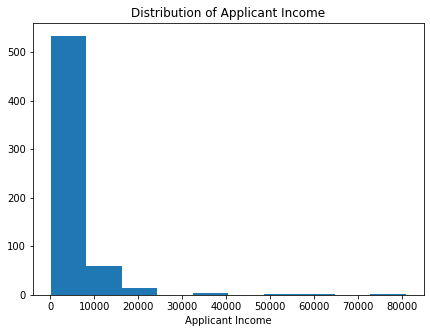

In [108]:
plt.figure(figsize = (7,5))
plt.hist(train.ApplicantIncome)
plt.xlabel("Applicant Income")
plt.title("Distribution of Applicant Income")
plt.show()

From the abundance of outliers from the boxplot above, the right skew of the applicant income distribution was expected. After our preliminary model, we can try and see if a logrithmic version of this income results in a better model prediction.

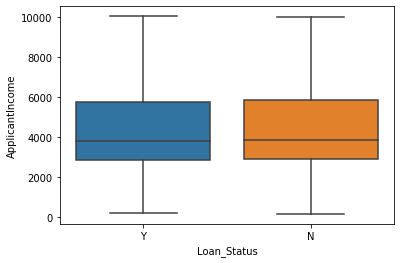

In [32]:
# Compare how applicant income differs with different loan status
sns.boxplot(y = train.ApplicantIncome, x = train.Loan_Status, showfliers = False)

It does not seem like the income has much effect on whether getting your loan application accepted or not, which was unexpected. Perhaps applicant income with respect to his/her loan amount is more important than the income alone.

<br> Coapplicant Income 

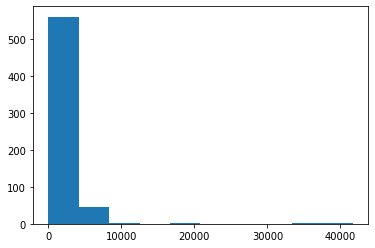

In [112]:
plt.hist(train.CoapplicantIncome)
plt.show()

Similar to applicant income, the distribution shows a right skew.

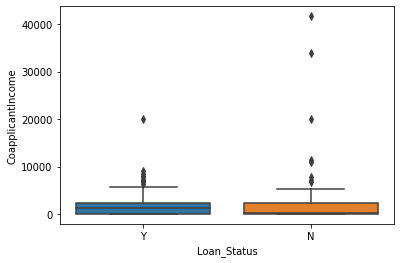

In [113]:
# Compare how coapplicant income differs with different loan status
sns.boxplot(y = train.CoapplicantIncome, x = train.Loan_Status)

<br> Loan amount and Loan Amount Term

In [116]:
# Descriptive statistics
train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

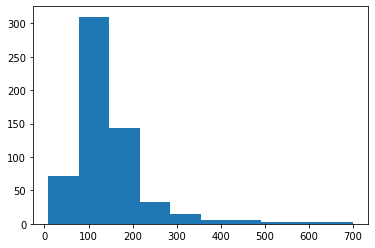

In [117]:
plt.hist(train.LoanAmount)
plt.show()

Again, this shows a skew towards the right. It is common for financial data to show a right skew.

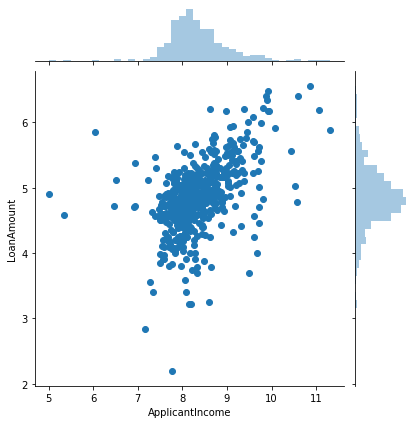

In [120]:
# See if there is a relationship between log-transformed loan amount and log-transformed applicant income
sns.jointplot(x = np.log(train.ApplicantIncome), y = np.log(train.LoanAmount))

The scatterplot shows that the log-transformed loan amount and log-tranformed applicant income seem to have a moderate positive correlation.

In [122]:
print("Median loan amount for declined applicants: ", train[train["Loan_Status"] == "N"].LoanAmount.median())
print("Median loan amount for accepted applicants: ", train[train["Loan_Status"] == "Y"].LoanAmount.median())

Median loan amount for declined applicants:  129.0
Median loan amount for accepted applicants:  126.0


Even though loan amount and applicant income seem correlated, that may not offer us much info about the label data, since the median loan amount for applicants accepted or declined a loan seems similar.

In [186]:
# Try feature engineering for LoanAmount
train["Loan_Amount_Groups"] = pd.qcut(train["LoanAmount"],3, labels = ["Low", "Medium", "High"])

In [134]:
train.groupby("Loan_Amount_Groups").Loan_Status.value_counts(normalize = True)

Loan_Amount_Groups  Loan_Status
Low                 Y              0.691542
                    N              0.308458
Medium              Y              0.738462
                    N              0.261538
High                Y              0.653061
                    N              0.346939
Name: Loan_Status, dtype: float64

Perhaps this is a feature that we can work with, and thus we can see if it performs better using cross validation.

In [123]:
train.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

This shows that this column should be a categorical variable instead.

In [187]:
# Change column type to categorical
train["Loan_Amount_Term"] = train["Loan_Amount_Term"].astype(np.object)

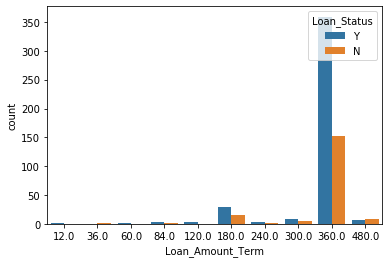

In [135]:
sns.countplot(train.Loan_Amount_Term, hue = train.Loan_Status)

It is difficult to say much about the data using this plot. Let's look at the data using a more quantitative approach.

In [136]:
train.groupby("Loan_Amount_Term").Loan_Status.value_counts(normalize = True)

Loan_Amount_Term  Loan_Status
12.0              Y              1.000000
36.0              N              1.000000
60.0              Y              1.000000
84.0              Y              0.750000
                  N              0.250000
120.0             Y              1.000000
180.0             Y              0.659091
                  N              0.340909
240.0             Y              0.750000
                  N              0.250000
300.0             Y              0.615385
                  N              0.384615
360.0             Y              0.701172
                  N              0.298828
480.0             N              0.600000
                  Y              0.400000
Name: Loan_Status, dtype: float64

The term also seems to be a promising column, but the normalization is misleading due to small sample sizes for some classes (ex:12)

In [140]:
train["Loan_Amount_Term"].value_counts(ascending = True)

12.0       1
36.0       2
60.0       2
120.0      3
84.0       4
240.0      4
300.0     13
480.0     15
180.0     44
360.0    512
Name: Loan_Amount_Term, dtype: int64

<br> Credit History

In [143]:
# This should be a categorical column as well
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [188]:
# Conversion to a categorical column
train.Credit_History = train.Credit_History.astype(np.object)

Univariate value counts
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64


Multivariate value counts w/ label data
Credit_History  Loan_Status
0.0             N              0.921348
                Y              0.078652
1.0             Y              0.795789
                N              0.204211
Name: Loan_Status, dtype: float64


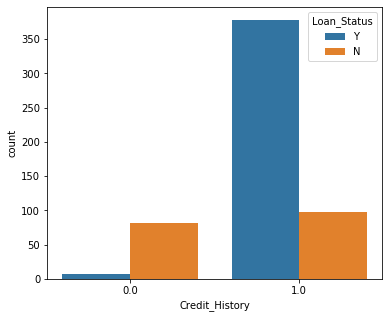

In [146]:
count_statistic("Credit_History")

This column seems to have a big impact on the loan status outcome. This is a great find, while also concerning, since the largest number of missing values for a column comes from this feature. As this is a binary feature, it is worthwhile to investigate the nature of these missing values. Are the values missing because of poor data quality, or does missing value suggest that their credit histories do not meet the guidelines?

In [154]:
# Creating a dataset with only rows in which the credit history column had null values
missing_creds = train[train["Credit_History"].isnull()]


In [153]:
# Checking distribution of loan statuses. 
missing_creds.Loan_Status.value_counts(normalize = True)

Y    0.74
N    0.26
Name: Loan_Status, dtype: float64

In [150]:
# Comparing with the whole dataset's distirbution of loan statuses
train.Loan_Status.value_counts(normalize = True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

If the missing values truly meant that the credit history should have been 0, then the percentage of declines for the loan should have been far greater than that of accepts. However, that was not the case, and thus we cannot conclude that the missing values have an intrinsic meaning.
<br>
Since this feature seems to be a strong signal, we need to be careful with how we impute the data. This leads me to conclude that a robust imputation method using machine learning seems to be the best choice.

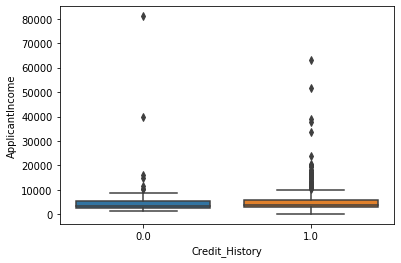

In [159]:
sns.boxplot(y = train.ApplicantIncome, x = train.Credit_History)

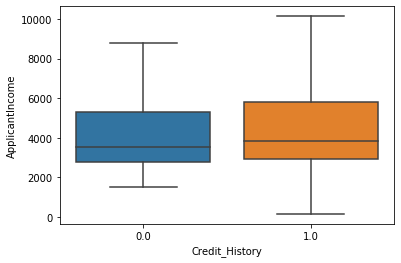

In [10]:
# Recreating boxplot due to outliers . This shows that applicants with higher income generally had a higher
# chance of having a credit history that meets guidelines
sns.boxplot(y = train.ApplicantIncome, x = train.Credit_History, showfliers = False)


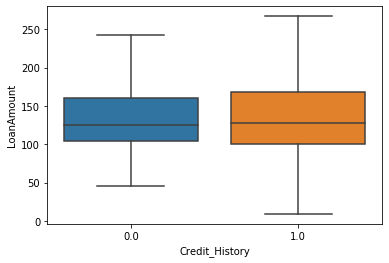

In [16]:
# Investigating relationship between credit history and the amount of loan. No definitive relationship.
sns.boxplot(x = train.Credit_History, y = train.LoanAmount, showfliers = False)

<br> Property Area

Univariate value counts
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64


Multivariate value counts w/ label data
Property_Area  Loan_Status
Rural          Y              0.614525
               N              0.385475
Semiurban      Y              0.768240
               N              0.231760
Urban          Y              0.658416
               N              0.341584
Name: Loan_Status, dtype: float64


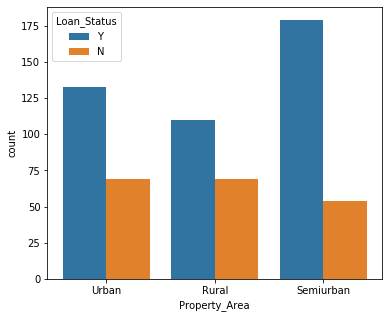

In [19]:
count_statistic("Property_Area")

It seems that loans for semi-urban property areas are disproportionally more likely to be accepted. However, it does not seem likely that this is a causal relationship, as the population that applies for loans for semiurban homes may be different than applicants for other areas. Let's look to see some confounding variables.

In [27]:
train.groupby("Property_Area").Credit_History.value_counts(normalize = True, sort = False)

Property_Area  Credit_History
Rural          0.0               0.169697
               1.0               0.830303
Semiurban      0.0               0.138249
               1.0               0.861751
Urban          0.0               0.170330
               1.0               0.829670
Name: Credit_History, dtype: float64

In [24]:
train.groupby(["Property_Area", "Credit_History"]).Loan_Status.value_counts(normalize = True, sort = False)

Property_Area  Credit_History  Loan_Status
Rural          0.0             N              0.928571
                               Y              0.071429
               1.0             N              0.284672
                               Y              0.715328
Semiurban      0.0             N              0.866667
                               Y              0.133333
               1.0             N              0.122995
                               Y              0.877005
Urban          0.0             N              0.967742
                               Y              0.032258
               1.0             N              0.231788
                               Y              0.768212
Name: Loan_Status, dtype: float64

It seems that there are slightly higher proportion of applicants that have good credit history for semi-urban properties over other properties. Not only that, even amongst the applicantions from applicants with good credit history, the applications for semi-urban properties have a high rate of acceptance.

In [28]:
train.groupby(["Property_Area", "Credit_History", "Loan_Status"]).ApplicantIncome.median()

Property_Area  Credit_History  Loan_Status
Rural          0.0             N              3595.0
                               Y              3700.0
               1.0             N              4583.0
                               Y              3846.0
Semiurban      0.0             N              3128.0
                               Y              5104.0
               1.0             N              4680.0
                               Y              3854.0
Urban          0.0             N              3173.0
                               Y              4333.0
               1.0             N              3600.0
                               Y              3583.5
Name: ApplicantIncome, dtype: float64

Interstingly, the highest median income out of these groups is the group of applicants without good credit history applying for semi-urban property loan that got a loan. It may possibly indicate that one is required a high income in order to get a loan despite one's credit history not meeting guidelines. However, the highest median income of applicants for rural properties is the group with good credit history that did not get their loans accepted. This further supports our idea that perhaps applicant income does not have a large effect on loan acceptance.

Now that we've developed an understanding of basic data distributions, preparing the data.

# Part 2 Data Preprocessing

As decided from EDA, I am going to be imputing missing values using a machine learning algorithm. I will use the miss forest imputation algorithm, which essentially imputes missing values by training a random forest algorithm to predict the missing values.

<br><br>
A mistake many data scientists make is data leakage during cross validation. The point of cross validation is to emulate a setting in which the model is evaluated with unseen data without using the test set. By doing imputations and scaling on the whole training set, and then performing cross validaion on that preprocesed dataset, you are introducing data leakage. This is because imputations and scalings use descriptive statistics, such as mean and standard deviation. The value of these statistics change with the data used to compute them. By computing these statistics prior to cross validating, you are essentially using test fold data (data that is supposed to be unseen) in the calculation for mean and standard deviation. Therefore, these preprocessing must occur after the training data has been split into folds.
<br>
<br>
Had I decided to use sklearn's SimpleImputer, I could have implemented this using sklearn's Pipeline with a ML classification model at the end of the pipeline, and use that entire pipeline as the model argument to sklearn's cross validations. However, because I want to use MissForest, I would need to take a more complex path for preprocessing. Using MissForest to impute variables requires all values of all columns to be numerical. This is why first I would need to label encode the categorical variables, and then use MissForest to impute them. However, label encoding isn't the most optimal way to encode categorical variables. Therefore, after the imputation I must then inverse transform the imputed columns back to their original labels, and finally perform one-hot encoding. However, sklearn's Pipeline does not allow inverse transformations to occur. Therefore, in order to implement this series of preprocessing, I will write a custom function rather than using pipelines.

In [10]:
# Separate to numerical and categorical features
cat = train.loc[:,train.dtypes == np.object].drop("Loan_Status", axis = 1)
cat_attributes = list(cat.columns)

numerical = train.loc[:,train.dtypes != np.object]
num_attributes = list(numerical.columns)

In [189]:
# Encode target features to 0 or 1
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
label = lab_enc.fit_transform(train.Loan_Status) # Encodes Yes as 1 and No as 0 (confirmed manually)

First create column transfer with a numerical pipeline that will scale numerical variable, then another pipeline that first imputes using missforest and then onehot encode then uses a classifier

For this function I will first use sklearn's Kfold to split the data into training and test folds. Then, I will impute the missing values on my training set using miss forest. Then the imputed training and the test set will be concatenated while remembering the length of the test set. Then the concatenated set will be imputed using another run of miss forest. Then the imputed concatenated set will be split into imputed training and imputed test set. Then, I will split both sets into categorical and numerical sets. Onehotencoder will be fit to the categorical training set, and using that encoder the test set will be encoded. A standard scaler will be fit to the numerical set, and then that scaler will be used to transform the test set. Finally, the preprocessed categorical and numerical sets will be concatenated for both the training and the test set, and will be modeled. This whole process will be repeated for every fold.

In [190]:
# Mapping numerical values to categorical variables and cleaning data for preprocessing function
# train.drop("Loan_Status", inplace = True, axis = 1)
gender_dict = {"Male":0, "Female":1}
mar_dict = {"No":0, "Yes":1}
train.Dependents = train.Dependents.replace("3+", 3, regex = True)
edu_dict = {"Graduate":0, "Not Graduate":1}
se_dict = {"No":0, "Yes":1}
prop_dict = {"Rural":0, "Semiurban":1, "Urban":2}
loan_term_dict = {12.0:0, 36.0:1, 60.0:2, 84.0:3, 120.0:4, 180.0:5, 240.0:6, 300.0:7, 360.0:8, 480:9}
loan_group_dict = {"Low":0, "Medium":1, "High":2}
# Helper function to map values
def mapper(dataset, col_name, dictionary):
    dataset[col_name] = dataset[col_name].map(dictionary)
    return dataset

cols = ["Gender", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Amount_Term", "Loan_Amount_Groups"]
dics = [gender_dict, mar_dict, edu_dict, se_dict, prop_dict, loan_term_dict, loan_group_dict]

# Mapping of numerical values to categorical values using helper function

for i in range(len(cols)):
    mapper(train,cols[i],dics[i])

# Confirm mapping
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Amount_Groups
0,LP001002,0.0,0.0,0,0,0.0,5849,0.0,NaN,8.0,1.0,2,Y,NaN
1,LP001003,0.0,1.0,1,0,0.0,4583,1508.0,128.0,8.0,1.0,0,N,1


In [191]:
# Dropping the label from the training data and saving it into y_train
train = train.drop("Loan_Status", axis = 1)
y_train = label

In [13]:
# Function to preprocess and perform k-fold cross validation
from missingpy import MissForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

scores = []
def preprocess_cv(training_data, categorical_indices_list, label_data, model, n_folds):
    scores = []
    kfold = StratifiedKFold(n_folds, True, 1)
    
    
    for train_i, test_i in kfold.split(training_data, label_data):

        # Initializing the datasets for the iteration
        X_train, X_test = training_data.iloc[train_i], training_data.iloc[test_i] # Creating training and testing inputs
        y_train, y_test = label_data[train_i], label_data[test_i] # Creating the corresponding labels for the training and testing inputs
        test_length = len(test_i) # Storing length of test set to separate from concatenated set later

        ########## Imputation of missing values
        imputer = MissForest(n_estimators = 50, verbose = 0)
        train_imputed = imputer.fit_transform(X_train, cat_vars = categorical_indices_list) # Imputing missing values using miss forest
        train_imputed = pd.DataFrame(train_imputed, columns = list(X_train.columns)) # Converting the imputed X_train to a dataframe
        imp_train_test = pd.concat([X_test, train_imputed], axis = 0) # Creating a full X set using testing and imputed training set
        imputer = MissForest(n_estimators = 50, verbose = 0)
        full_imputed = imputer.fit_transform(X = imp_train_test, cat_vars = categorical_indices_list) #Imputing the test set portion using full set
        full_imputed = pd.DataFrame(full_imputed, columns = list(X_train.columns)) # Converting the imputed full set to a dataframe
        imp_X_test, imp_X_train = full_imputed.iloc[0:len(test_i)], full_imputed.iloc[len(test_i):] # Reverting back to training and test sets


        ########## Preprocessing of categorical and numerical columns

        # Categorical
        cat_train = imp_X_train.iloc[:, categorical_indices_list]
        cat_test = imp_X_test.iloc[:, categorical_indices_list]
        cat_attributes = list(cat_train.columns)
        # One hot encoding training data
        onehot = OneHotEncoder(handle_unknown = "ignore")
        encoded_train = onehot.fit_transform(cat_train)
        onehotted_train_df = pd.DataFrame(encoded_train.toarray(), columns = onehot.get_feature_names(cat_train.columns), index = cat_train.index)
        encoded_test = onehot.transform(cat_test)
        onehotted_test_df = pd.DataFrame(encoded_test.toarray(), columns = onehot.get_feature_names(cat_test.columns), index = cat_test.index)

        # Numerical
        num_train = imp_X_train[imp_X_train.columns.difference(cat_attributes)] # Getting numerical columns by selecting columns that are not in list of categorical column names
        num_test = imp_X_test[imp_X_test.columns.difference(cat_attributes)] # Getting test set the same way                                                   
        # Standard scaling
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(num_train)
        scaled_num_train = pd.DataFrame(scaled_train, columns = num_train.columns, index = num_train.index)
        scaled_test = scaler.transform(num_test)
        scaled_num_test = pd.DataFrame(scaled_test, columns = num_test.columns, index = num_test.index)


        X_train = pd.concat([onehotted_train_df, scaled_num_train], axis = 1) # Concatenating the preprocessed training input data
        X_test = pd.concat([onehotted_test_df, scaled_num_test], axis = 1) # Concatenating the preprocessed test input data


        ########## performing cross validation (User defined model, testing with LGBM)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        print(score)
        scores.append(score)
        
    return scores

    
    
    
    


In [ ]:
# Performing imputation and cross-validation for Light GBM model to determine whether this method leads to a less biased cross-validation.
lgbm = LGBMClassifier()

scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10,11], label, lgbm, 5)
np.mean(scores_list)

The mean AUC for the model was around 0.7165. I've omitted the output for legibility of the notebook.

Now I will compare the performance of this imputation/cross-validation methods with other methods. Namely, naive data-leakage method using SimpleImputer and naive data-leakage method using MissForest. My prediction is that the naive data-leakage MissForest method will lead to the higest cross-validation score, followed by the naive data-leakage method with SimpleImputer. I believe that this no data-leakage approach will lead to the lowest score, but will also emulate real-life situation the most accurately. If naive SimpleImputer method leads to higher score than the MissForest method, then I will adopt using SimpleImputer over MissForest for my cross-validation, as it is far less computationally expensive. 

In [14]:
# Comparing this imputation results with other imputation methods
train2 = pd.read_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Loan Prediction Project\train_ctrUa4K.csv")
train2.drop(["Loan_Status","Loan_ID"], axis = 1, inplace = True)

In [ ]:
# Naive cross-validation preprocessing: imputation using SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("num_imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "most_frequent")),
    ("encoder", OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attributes),
    ("categorical", cat_pipeline, cat_attributes)
])

X_train2 = full_pipeline.fit_transform(train2)

In [427]:
# Performing 5-fold CV on data with data leakage
from sklearn.model_selection import cross_val_score
lgbm = LGBMClassifier()
scores = cross_val_score(lgbm, X_train2, y_train, scoring = "roc_auc")

In [428]:
np.mean(scores)

0.7587785262553064

The AUC of the cross-validation with data leakage did indeed end up with a higher score, and hence proves that data leakage leads to optimistic evaluation of the model.

In [ ]:
# Naive cross-validation preprocessing: imputation using MissForest
imputer = MissForest(n_estimators = 250, verbose = 0)
train_imputed = imputer.fit_transform(train, cat_vars = [0,1,2,3,4,8,9,10,11])

num_pipeline = Pipeline([
    
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    
    ("encoder", OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attributes),
    ("categorical", cat_pipeline, cat_attributes) ])

train_imputed = pd.DataFrame(train_imputed, columns = train.columns)
    
X_train3 = full_pipeline.fit_transform(train_imputed)

In [424]:
# Performing 5-fold CV on data with data leakage
from sklearn.model_selection import cross_val_score
lgbm = LGBMClassifier()
scores = cross_val_score(lgbm, X_train3, y_train, scoring = "roc_auc")

In [425]:
np.mean(scores)

0.7619673618435229

My prediction was validated that data leakage led to higher AUC, but MissForest imputation led to slightly higher AUC than SimpleImputer.

Now that the most unbiased cross-validation technique is established, I will use my function to try out different models.

# Part 3 Model Selection

I will first try out Random Forest, Kernel SVM (with gaussian radial basis function kernel), XG Boost, and Logistic Regression without hyperparameter tuning. I will compare the average AUC scores, and then I will choose the models with the highest AUC scores to hyperparameter tune. 

In [ ]:
# Omitted output for notebook legibility. Trial 1 with Loan_Amount_Group as discrete variable
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = "l1", solver = "liblinear")
xbg = XGBClassifier()
rf = RandomForestClassifier()
svc = SVC(kernel = 'rbf')


model_list = [lr, xbg, rf, svc]
model_avg_score = {}
for model in model_list:
    np.random.seed(1)
    scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10,11], label, model, 5)
    model_avg_score[model] = np.mean(scores_list)
    print(f"{model} average accuracy: {np.mean(scores_list)}")

In [231]:
# Random Forest yielded the highest AUC, beating that of Light GBM. 
model_avg_score

{LogisticRegression(penalty='l1', solver='liblinear'): 0.7080861656403452,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None): 0.6967481486521734,
 RandomForestClassifier(): 0.7196911963165833,
 SVC(): 0.6989527551911452}

In [ ]:
# Omitted output for notebook legibility. Trial 2 with Loan_Amount_Group as continuous variable
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = "l1", solver = "liblinear")
xbg = XGBClassifier()
rf = RandomForestClassifier()
svc = SVC(kernel = 'rbf')

model_list = [lr, xbg, rf, svc]
model_avg_score = {}
for model in model_list:
    np.random.seed(1)
    scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10], label, model, 5)
    model_avg_score[model] = np.mean(scores_list)
    print(f"{model} average accuracy: {np.mean(scores_list)}")

In [236]:
model_avg_score

{LogisticRegression(penalty='l1', solver='liblinear'): 0.7119082207781898,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None): 0.7006631397498271,
 RandomForestClassifier(): 0.70635933725717,
 SVC(): 0.7015843341385137}

The models with the highest average AUC in this experiment were the Random Forest and Logistic Regression. Light GBM's average AUC was 0.71653, which is slightly lower than that of the Random Forest when Loan Amount Group column was considered a discrete categorical variable. Therefore, I will proceed with hyperparameter tuning a light gbm, logistic regression, and a random forest model. Before proceeding to optimize this model, I will try a few data transformations to see if it can improve model performance. The data transformations I will be doing are
<br>
<br>
1. Log transformation of data that showed right skew
<br>
<br>
2. Fixing class imbalance issue via oversampling methods.



# Part 4 Data Transformation and Feature Selection

In [129]:
# Importing dataset for experimentation
train2 = pd.read_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Loan Prediction Project\train_ctrUa4K.csv")
train2.drop(["Loan_Status","Loan_ID"], axis = 1, inplace = True)

In [130]:
# Performing a log-transformation to make the numerical data estimate a normal distribution
train2["ApplicantIncome"] = np.log(train2["ApplicantIncome"])
train2["CoapplicantIncome"] = np.log(train2["CoapplicantIncome"])
train2["LoanAmount"] = np.log(train2["LoanAmount"])
train2["Loan_Amount_Groups"] = pd.qcut(train2["LoanAmount"],3, labels = ["Low", "Medium", "High"])

C:\Users\taked\AppData\Roaming\Python\Python37\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [125]:
# Check to see if the log-transformation was successful: there is a negative infinity due to log(0)
train2.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,8.674026,-inf,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,8.430109,7.31854,4.852030,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,8.006368,-inf,4.189655,360.0,1.0,Urban


In [131]:
# Fix the negative infinity found in CoapplicantIncome
train2.CoapplicantIncome.replace(-np.inf, 0, inplace = True)

In [132]:
# Mapping numerical values to categorical variables in this second dataset
train2.Dependents = train2.Dependents.replace("3+", 3, regex = True)

for i in range(len(cols)):
    mapper(train2,cols[i],dics[i])

In [ ]:
# Perform stratified 5-fold cross validation and compare scores: previous score: 0.71653
lgbm = LGBMClassifier()

scores_list = preprocess_cv(train2, [0,1,2,3,4,8,9,10], label, lgbm, 5)


In [199]:
np.mean(scores_list)

0.7062641331836379

There was about a 0.1 decrease in AUC. Therefore, I will keep the original numerical data without log transformation. One thing to keep in mind is that tree-based algorithms, such as Light GBM are less affected by different scales than other algorithms, such as Logistic Regression.

Now, I will try oversampling methods to see if adjusting class imbalance will increase AUC.

In [202]:
# Adding a SMOTE synthetic sampling method to increase samples with declined loan cases
from imblearn.over_sampling import SMOTE

def preprocess_smote_cv(training_data, categorical_indices_list, label_data, model, n_folds):
    scores = []
    kfold = StratifiedKFold(n_folds, True, 1)
    
    
    for train_i, test_i in kfold.split(training_data, label_data):

        # Initializing the datasets for the iteration
        X_train, X_test = training_data.iloc[train_i], training_data.iloc[test_i] # Creating training and testing inputs
        y_train, y_test = label_data[train_i], label_data[test_i] # Creating the corresponding labels for the training and testing inputs
        test_length = len(test_i) # Storing length of test set to separate from concatenated set later

        ########## Imputation of missing values
        imputer = MissForest(n_estimators = 50, verbose = 0)
        train_imputed = imputer.fit_transform(X_train, cat_vars = categorical_indices_list) # Imputing missing values using miss forest
        train_imputed = pd.DataFrame(train_imputed, columns = list(X_train.columns)) # Converting the imputed X_train to a dataframe
        imp_train_test = pd.concat([X_test, train_imputed], axis = 0) # Creating a full X set using testing and imputed training set
        imputer = MissForest(n_estimators = 50, verbose = 0)
        full_imputed = imputer.fit_transform(X = imp_train_test, cat_vars = categorical_indices_list) #Imputing the test set portion using full set
        full_imputed = pd.DataFrame(full_imputed, columns = list(X_train.columns)) # Converting the imputed full set to a dataframe
        imp_X_test, imp_X_train = full_imputed.iloc[0:len(test_i)], full_imputed.iloc[len(test_i):] # Reverting back to training and test sets


        ########## Preprocessing of categorical and numerical columns

        # Categorical
        cat_train = imp_X_train.iloc[:, categorical_indices_list]
        cat_test = imp_X_test.iloc[:, categorical_indices_list]
        cat_attributes = list(cat_train.columns)
        # One hot encoding training data
        onehot = OneHotEncoder(handle_unknown = "ignore")
        encoded_train = onehot.fit_transform(cat_train)
        onehotted_train_df = pd.DataFrame(encoded_train.toarray(), columns = onehot.get_feature_names(cat_train.columns), index = cat_train.index)
        encoded_test = onehot.transform(cat_test)
        onehotted_test_df = pd.DataFrame(encoded_test.toarray(), columns = onehot.get_feature_names(cat_test.columns), index = cat_test.index)

        # Numerical
        num_train = imp_X_train[imp_X_train.columns.difference(cat_attributes)] # Getting numerical columns by selecting columns that are not in list of categorical column names
        num_test = imp_X_test[imp_X_test.columns.difference(cat_attributes)] # Getting test set the same way                                                   
        # Standard scaling
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(num_train)
        scaled_num_train = pd.DataFrame(scaled_train, columns = num_train.columns, index = num_train.index)
        scaled_test = scaler.transform(num_test)
        scaled_num_test = pd.DataFrame(scaled_test, columns = num_test.columns, index = num_test.index)


        X_train = pd.concat([onehotted_train_df, scaled_num_train], axis = 1) # Concatenating the preprocessed training input data
        X_test = pd.concat([onehotted_test_df, scaled_num_test], axis = 1) # Concatenating the preprocessed test input data
        
        
        # Adding SMOTE to create new negative class samples
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)


        ########## performing cross validation (User defined model, testing with LGBM)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        print(score)
        scores.append(score)
        
    return scores

In [ ]:
# Experiment 1: Run cross validation without synthetic sampling

lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10,11], label, lgbm, 5)


In [212]:
print("AUC without oversampling: ",np.mean(scores_list))

AUC without oversampling:  0.7071759716032162


In [ ]:
# Experiment 2: Run cross validation without synthetic sampling, but treating Loan_Amount_Groups as an ordinal feature

lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10], label, lgbm, 5) # not considering Loan_Amount_Groups as categorical variable 

In [215]:
print("AUC without oversampling: ",np.mean(scores_list))

AUC without oversampling:  0.708290239172592


In [ ]:
# Experiment 3: Run cross validation without synthetic sampling, but treating Dependent and Loan_Amount_Groups as an ordinal feature

lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores_list = preprocess_cv(train, [0,1,3,4,8,9,10], label, lgbm, 5) # not considering Loan_Amount_Groups as categorical variable 

In [218]:
print("AUC without oversampling: ",np.mean(scores_list))

AUC without oversampling:  0.7000523934270064


In [ ]:
# Experiment 4: Run cross validation with synthetic sampling
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores_list = preprocess_smote_cv(train, [0,1,2,3,4,8,9,10,11], label, lgbm, 5)


In [210]:
print("AUC with oversampling: ",np.mean(scores_list))

AUC with oversampling:  0.699281971898071


The series of experiments yielded some important insights:
<br>
1. Synthetic sampling yields poorer results. Research shows that synthetic sampling yields best results when coupled with undersampling of the majority class. However, I will decide to forgo synthetic sampling altogether, as undersampling a small dataset (~600 instances) seems counterproductive.
<br>
2. Considering Loan Amount Groups as a continuous variable led to an increase in AUC by 0.01. However, the actual efficacy of the reconsideration of the variable type remains uncertain due to the stochastic nature of the evaluation process. 

<br>
<br>
From these findings, I will be not using a resampling method, and for now I will choose to consider Loan Amount Group as a categorical variable. Quantifying uncertainty via statistical methods is too computationally intensive without a justifying return in model performance. Thus I will stay on the conservative end and proceed with the original training data.

In [84]:
# Trying if removing columns would help
train3 = train.drop(columns = ["Self_Employed", "ApplicantIncome"])

In [ ]:
# Run cv again with the modified dataset
lgbm = LGBMClassifier()

scores_list = preprocess_cv(train3, [0,1,2,3,6,7,8], label, lgbm, 5)
np.mean(scores_list)


When dropping Self_Employed and ApplicantIncome columns, the average AUC dropped to 0.6942260628947936 (omitted output for legibility), signifying that there are mulivariate relationships between those variables, the other variables in the training set, and loan status. Therefore, I will keep those features for downstream modeling.

Now I will be experimenting to determine whether having both Loan Amount Groups and Loan Amount variables will yield a higher AUC score than keeping either one of the variables. I will be controlling the seed and the random state of the model to ensure the difference in scores are not due to chance.

In [97]:
train4 = train.drop("Loan_Amount_Groups", axis = 1)

In [ ]:
# Experiment 1: Try training without Loan_Amount_Groups (output omitted)
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores_list = preprocess_cv(train4, [0,1,2,3,4,8,9,10], label, lgbm, 5)
np.mean(scores_list)


In [114]:
print("No Loan Amount Group AUC: ",np.mean(scores_list))


No Loan Amount Group AUC:  0.7010544460699261


In [ ]:
# Experiment 2: Try training with Loan_Amount_Groups (output omitted)
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)

scores_list = preprocess_cv(train, [0,1,2,3,4,8,9,10,11], label, lgbm, 5)
np.mean(scores_list)

In [42]:
print("With Loan Amount Group AUC: ",np.mean(scores_list))


With Loan Amount Group AUC:  0.7071759716032162


In [ ]:
# Experiment 3: Try training with Loan_Amount_Groups and without LoanAmount (output omitted)
lgbm = LGBMClassifier(random_state = 1)
# train5 = train.drop("LoanAmount", axis = 1)
np.random.seed(1)

scores_list = preprocess_cv(train5, [0,1,2,3,4,7,8,9,10], label, lgbm, 5)
np.mean(scores_list)

In [118]:
print("With Loan Amount Group & No LoanAmount AUC: ",np.mean(scores_list))


With Loan Amount Group & No LoanAmount AUC:  0.6963880288957689


It turned out the dataset with both LoanAmount and the feature engineered column of Loan_Amount_Groups result in the highest AUC. Therefore, I will go with the original dataset.

Lastly, I will try a new feature. The feature I will try is named TotalIncome, which will be the summation of applicant income and coapplicant income. I'll see if those features or the log-transformation of them will improve model score.

In [197]:
train.head(1)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Amount_Groups
0,0.0,0.0,0,0,0.0,5849,0.0,NaN,8.0,1.0,2,NaN


In [195]:
# Preparing datasets for expeirmentation
train_total = train.copy()
train_total["TotalIncome"] = train_total["ApplicantIncome"] + train_total["CoapplicantIncome"]
train_total_log = train_total.copy()
train_total_log["TotalIncome"] = np.log(train_total_log["TotalIncome"])

# Drop the original columns
train_total = train_total.drop(columns = ["ApplicantIncome", "CoapplicantIncome"], axis = 1)
train_total_log = train_total_log.drop(columns = ["ApplicantIncome", "CoapplicantIncome"], axis = 1)

In [ ]:
# Base Case: 
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)

scores_list = preprocess_cv(train, [0,1,2,3,4,7,8,9,10,11], label, lgbm, 5)
np.mean(scores_list)


In [199]:
print("Base case with no total income column: ",np.mean(scores_list))

Base case with no total income column:  0.698599836695812


In [ ]:
# Experiment 1: Try training with untransformed version of the new features
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)

scores_list = preprocess_cv(train_total, [0,1,2,3,4,6,7,8,9], label, lgbm, 5)


In [202]:
print("Untransformed version of total income column: ",np.mean(scores_list))

Untransformed version of total income column:  0.73004638292564


In [ ]:
# Experiment 2: Try training with transformed version of the new features
lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)

scores_list = preprocess_cv(train_total_log, [0,1,2,3,4,6,7,8,9], label, lgbm, 5)

In [204]:
print("Transformed version of total income column: ",np.mean(scores_list))

Transformed version of total income column:  0.7172600619195046


The new feature engineered feature provided a great boost to the validation average AUC. Therefore, I will proceed using this new feature in place of Applicant Income and Coapplicant Income

In [205]:
# Modify the training data in accordance with the new finidngs
train["TotalIncome"] = train["ApplicantIncome"]+train["CoapplicantIncome"]
train.drop(columns = ["ApplicantIncome","CoapplicantIncome"], axis = 1, inplace = True)

# Part 5 Hyperparameter Optimization

For the hyperparameter tuning, I will have to compromise with some data leakage by using RandomizedSearchCV with preprocessing done prior to the splitting of folds. This is because it is way too computationally expensive and inefficient to fit a MissForest to the data for imputation at each iteration of the search. I will explore the hyperparameter spaces of Light GBM, Random Forest, and Logistic Regression.
<br><br>
I will first start off by running the three algorithms with the data leakage cross-validation method to compute the base average AUC of the models and see if the tuning can improve their scores.

In [233]:
# Gathering names of numerical and categorical columns
numerical_columns = ["LoanAmount", "TotalIncome"]
categorical_columns = [col for col in list(train.columns) if col not in numerical_columns]


In [19]:
# Naive cross-validation preprocessing: imputation using MissForest (copied from previously)

from sklearn.preprocessing import StandardScaler
from missingpy import MissForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
imputer = MissForest(n_estimators = 250, verbose = 0)
train_imputed = imputer.fit_transform(train, cat_vars = [0,1,2,3,4,6,7,8,9])
# from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    
    ("encoder", OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, numerical_columns),
    ("categorical", cat_pipeline, categorical_columns)])

train_imputed = pd.DataFrame(train_imputed, columns = train.columns)
    
X_train = full_pipeline.fit_transform(train_imputed)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [87]:
# Base cross_validation score for LGBM
from sklearn.model_selection import cross_val_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

lgbm = LGBMClassifier(random_state = 1)
np.random.seed(1)
scores = cross_val_score(lgbm, X_train, label, scoring = "roc_auc")

print("Base CV AUC Score for LGBM: ", np.mean(scores))

Base CV AUC Score for LGBM:  0.7286704128344995


In [93]:
# Base cross_validation score for Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
np.random.seed(1)
scores = cross_val_score(lr, X_train, label, scoring = "roc_auc")

print("Base CV AUC Score for Logistic Regerssion: ", np.mean(scores))

Base CV AUC Score for Logistic Regerssion:  0.7710115409186618


In [117]:
# Base cross_validation score for Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
np.random.seed(1)
scores = cross_val_score(rf, X_train, label, scoring = "roc_auc")

print("Base CV AUC Score for Random Forest: ", np.mean(scores))

Base CV AUC Score for Random Forest:  0.7441803037004274


So far Logistic Regession is performing the best with an average AUC of 0.77. It may be the case that the other two ensemble methods have very high variance. Possibly adding some regularization to these ensemble methods will increase their performances.

Light GBM

In [88]:
# Define the parameters to explore
lgbm_param = {
    "num_leaves": np.append(np.arange(5,100,10),31), # Appending default of 31
    "max_depth": np.append(np.arange(5, 200, 4),np.array([-1,-1,-1,-1,-1])), # Appending default of -1, while increasing its chance of being picked
    "learning_rate": [0.01,0.1, 0.3, 0.5],
    "subsample": [0.3, 0.5, 0.8, 1],
    "colsample_bytree": [0.3, 0.5, 0.8, 1],
    "min_child_samples": np.arange(0, 300, 10),
    "n_estimators": np.arange(1,50,3),
    "reg_alpha": [0, 0.1, 0.3, 0.5, 0.8, 1],
    "reg_lambda": [0, 0.1, 0.3, 0.5, 0.8, 1]
}

In [540]:
from sklearn.model_selection import RandomizedSearchCV
lgbm = LGBMClassifier()
search = RandomizedSearchCV(lgbm, lgbm_param, random_state = 0, n_iter = 500, n_jobs = -1, scoring = "neg_log_loss")
lgbm_search = search.fit(X_train, label)

In [355]:
lgbm_best = lgbm_search.best_estimator_
lgbm_search.best_params_

{'subsample': 1,
 'reg_lambda': 0.3,
 'reg_alpha': 0.1,
 'num_leaves': 35,
 'n_estimators': 10,
 'min_child_samples': 40,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.3}

In [537]:
np.random.seed(1)
scores = cross_val_score(lgbm_best, X_train, label, scoring = "roc_auc")
np.mean(scores)

0.7603590140509645

The light GBM model's average validation AUC increased about 3%, although its still not as high as that of logistic regression.

Random Forest

In [89]:
rf_param = {
    "n_estimators": [10, 30, 50, 100, 150, 200, 250, 300],
    "max_depth": np.append(np.arange(5, 200, 4),np.array([None, None, None])), # Appending default of None, while increasing its chance of being picked
    "max_features": [0.3, 0.5, 0.8, 1],
    "min_samples_leaf": np.arange(0, 300, 10),
    "criterion": ["gini", "entropy"],
    "min_samples_split": np.arange(0,50, 2),
    "n_jobs": [-1]}
    
    

In [131]:
rf = RandomForestClassifier()
search = RandomizedSearchCV(rf, rf_param, random_state = 0, n_iter = 500, n_jobs = -1, scoring = "roc_auc")
rf_search = search.fit(X_train, label)

In [132]:
rf_search.best_params_

{'n_jobs': -1,
 'n_estimators': 150,
 'min_samples_split': 14,
 'min_samples_leaf': 30,
 'max_features': 1,
 'max_depth': 153,
 'criterion': 'entropy'}

In [133]:
rf_best = rf_search.best_estimator_

In [134]:
np.random.seed(1)
scores = cross_val_score(rf_best, X_train, label, scoring = "roc_auc")
np.mean(scores)

0.7689273712183928

The average AUC for random forest increased, but still is not as high as that of logistic regression. <br>

<br>

Logistic Regression

Because the hyperparameter space is smaller than that of ensemble methods, I will use GridSearchCV for tuning.

In [147]:
# Defining hyperparameter space
lr_param = {
    "penalty": ["l1","l2"],
    "C": [i for i in range(1,10)],
    "solver" :["liblinear"],
    "fit_intercept": [True, False]   
}

In [377]:
# Performing grid search to tune the Logistic Regression model
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
search = GridSearchCV(lr, lr_param, scoring = "neg_log_loss")
lr_search = search.fit(X_train, label)

In [378]:
# Storing the best model and checking its hyperparameters.
lr_best = lr_search.best_estimator_
lr_search.best_params_

{'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

In [146]:
# Evaluating the tuned logistic regression model
np.random.seed(1)
scores = cross_val_score(lr_best, X_train, label, scoring = "roc_auc")
np.mean(scores)

0.7754529423105274

The average AUC increased by around 0.04 percent after the tuning.

I have predicted the labels on the test set for this competition on all three models. The Light GBM model had the best test set performance with score of 0.784722222222222. I ended up creating a voting classifier between the Logistic Regression model and the Light GBM model, which scored the test accuracy of 0.7916666667. This score got me into top 10% of the leaderboard for this competition. The score is merely 1% away from breaking into top 1% of the leaderboard, but I am not going go try and improve the score for this competition any furthur. Rather, I want to treat this project as an actual business problem, and create a model optimized for the business.

# Part 6 Threshold Optimazation

As suggested in the introduction, this competition simulates that the competitor works at a financial company that provides loans for homes, and the goal is to create a model that assesses loan-eligibility. The goal of the company is to deploy a classification model that predicts whether an applicant shall be granted a loan or not. Knowing that the business objective is to automate loan eligibility and that the key stakeholders are the decision makers of the financial company, two things can be done to improve the outcome and to get organizational buy-in for the project.
<br>
1. Change the prediction threshold to optimize the model predictions with respect to the business problem.
<br>
2. Make the model interpretable to present to stakeholders.
<br>
<br>


Giving out loans to unqualified applicants will negatively impact the company. The degree to which this misclassification impacts the company is greater than the misclassification situation, which is to not give out loans to qualified applicants. Therefore, we would like to minimize the former type of classification errors. In machine learning terms, we would like to minimize false positives by improving the true negative rate (accurately predicting to decline the loan application when the application is to be declined.) 

Because the true negative rate, also known as sensitivity, is 1 - the false positive rate, we can effectively improve the true negative rate by choosing a threshold that has a low false positive rate. The easiest way to minimize false positive rate is to make the prediction threshold so high, that the model predicts only negative classes. However, this obviously compromises the model performance. Therefore, we need to find a prediction threshold that can lower the false positive rate without hurting too much of the overall model performance <br>
Luckily, it is easy to assess the relationship of false positive rates with respect to different prediction thresholds. We can plot the ROC AUC curve to qualitatively analyze the dynamic relationship between false positive rate, prediction threshold, and model performance.

In [413]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Make model predictions 
lr = LogisticRegression(class_weight = 'balanced')

y_scores = cross_val_predict(lr, X_train, label, method = "decision_function")

# Find false positive rate, true positive rate, and different probability thresholds 
fpr, tpr, thresholds = roc_curve(label, y_scores)

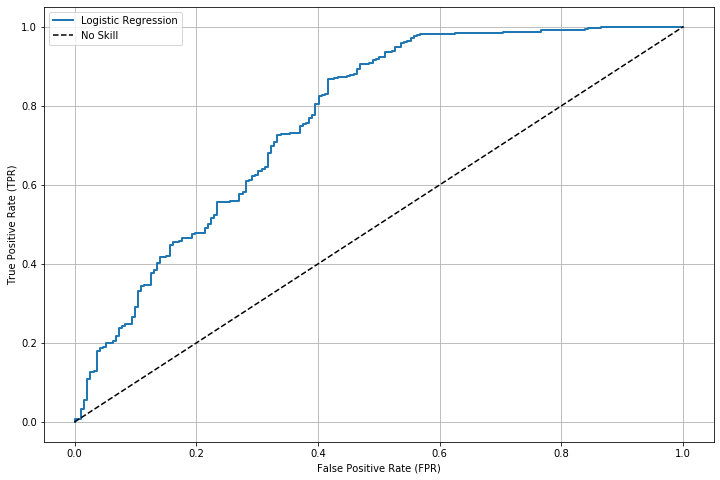

In [414]:
# Plot the roc curve

def plot_roc(fpr, tpr):
    plt.figure(figsize = (12, 8))
    plt.grid()
    plt.plot(fpr, tpr, linewidth = 2, label = "Logistic Regression")
    plt.plot([0,1], [0,1], 'k--', label = "No Skill")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.show()

plot_roc(fpr,tpr)

At first glance, it is difficult just from this graph alone to determine how much tradeoff of lower FPR vs lower TPR is optimal. In theory, if it is more expensive to misclassify a loan application that was supposed to be declined, then it would make sense to decrease the false positive rate. However, the dynamic of the tradeoff is furthur complicated by the model's probabilistic predictive capabilities; if the model's probability predictions are very poor for the declined applications (predicts a high probability for the accepting the loan when the loan actually should be declined), then increasing the threshold to increase the model's true negative rate may severely decrease the model's overall accuracy. 
<br><br>

In such cases, with the knowledge of expected profit/loss for every prediction situation, we can derive the optimal probability threshold that maximizes overall profits for the company.
<br><br>

Suppose that an accurate prediction of declining a loan is an expected profit of 300 utility for the company. This is because although there is technically no new business added for the company, administrative costs were saved by automating the application checking process rather than employing a human expert. Suppose that an incorrect prediction of declining a loan, when the loan should have been accepted, is an expected loss of 500 utility for the company. This is because the company lost an opportunity to make a profit by handing out the loan. <br>
Suppose that an accurate prediction of accepting a loan is an expected profit of 800 utility, because the company was able to make a profit from loaning to a suited applicant, while simultaneously saving administrative costs. <br>
Finally, suppose that an incorrect prediction of accepting the loan for an applicantion that shouldn't have been accepted is an expected loss of 2000 utility because the company will be engaging in a very risky loan. <br><br>

The expected profit relationship of the different outcomes are summarized below.

                          prediction
        
                  decline            accept 

       decline     300                -2000 
       
actual            
       
       accept     -500                 800 

<br>
Using this relationship we can compute the expected profit at each threshold for the model, and find the probability threshold that maximizes the expected profit.

In [483]:
y_scores = cross_val_predict(lr, X_train, label)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,y_scores)

false_positive_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False positive rate at default prediction threshold: {false_positive_rate}")

False positive rate at default prediction threshold: 0.4166666666666667


In [479]:
# Running an algorithm that computes expected profit at different probability thresholds for classification

prob_thresholds = [i for i in range(101)]
y_probas = cross_val_predict(lr, X_train, label, method = "predict_proba")
expected_profits = []

for threshold in prob_thresholds:
    y_pred = np.where(y_probas[:,1] >= threshold*0.01, 1, 0) # Assigning classes based on probability thresholds
    cm = confusion_matrix(label,y_pred)
    expected_profit_true_negative = cm[0,0] * 300           # Gaining 200 utility for every correct prediction of decline
    expected_profit_false_negative = cm[1,0] * -500 # Losing 500 utility for every incorrect prediction of decline when loans could have been accepted
    expected_profit_true_positive = cm[1,1] * 800           # Gaining 700 utility for every correct prediction of accepting loans
    expected_profit_false_positive = cm[0,1] * -2000        # Losing 1000 utility for every incorrect prediction of accepting loans
    total_expected_profit = expected_profit_true_negative + expected_profit_false_negative + expected_profit_true_positive + expected_profit_false_positive
    
    expected_profits.append(total_expected_profit)

In [498]:
# Finding the probability threshold that maximized expected profits
optimal_prob = prob_thresholds[np.argmax(expected_profits)]

# Finding the optimized profit
optimal_profit = expected_profits[optimal_p]

# Analysis
print(f"By lowering the probability threshold by {50 - optimal_prob} percent, we are able to increase company profits from {expected_profits[51]} units to {optimal_profit} units.")

By lowering the probability threshold by 14 percent, we are able to increase company profits from 115400 units to 136200 units.


In [499]:
# Check false positive rate at the new probability threshold
y_predict_new_thresh = np.where(y_probas[:,1] >= prob_thresholds[np.argmax(expected_profits)]*0.01, 1, 0)
cm = confusion_matrix(label,y_predict_new_thresh)
false_positive_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(false_positive_rate)

0.5364583333333334


This unintuitive increase in false positive rate for maximized profits highlight the complexity of threshold optimizations. Although I set the expected profit values for each situation based on logic, they are nontheless abstract. Different configurations of the profit values will result in different optimal thresholds and maximized expected profits. Now, I will move onto model interpretability.

# Part Final: Model Interpretation and Uncertainty

As a decision maker in business, it is difficult to determine whether automating key business processes with machine learning is necessarily a good idea. The matter is furthur complicated if the models aren't highly accurate while the traditional human approach almost always is. In order to convince the decision makers that there is a merit to adopt models, it is important to make the model decisions as transparent as possible. Afterall, would you trust the future of your business, and consequently the future of your family, your employees, and their families to a machine that mysteriously outputs predictions? <br><br>

Therefore, it is important to present the model to stakeholders by providing information that will aid the stakeholders' business decisions. Namely, they will be metrics that answers questions such as: 
<br><br>
1. What are the variables that the model is taking into consideration when making predictions? Do they align with our business intuition/domain expertise? 
<br><br>
2. To what extent can we trust the model performance?

<br>
The first question can be answered by computing shapley values. To be put in a simple way, shapley values numerically express the influence each variable had on the model's predictions. This is done by quantifying each variable's influence on reducing the errors of prediction. Note that shapley values merely highlight how each variables affected the decision outcome in the particular model, and it is in no way a method to infer causation. Nevertheless, it serves the purpose of aligning knowledge with domain experts to see if the variables that the model chose as the most influencial make business sense.

First I will reprocess my training data such that the columns are interpretable with column names even after OneHot Encoding.

In [511]:
# Reversing the key and value pair to map back the actual values to the imputed dataframe
reversed_dics = []
for i in range(len(dics)):
    res = dict((v,k) for k,v in dics[i].items())
    reversed_dics.append(res)
    


In [509]:
# Finding column names of numerical and categorical columns for preprocessing
numerical_columns = ["LoanAmount", "TotalIncome"]
categorical_columns = [col for col in list(train.columns) if col not in numerical_columns]

# Converting categorical columns to object type
train.loc[:,categorical_columns] = train.loc[:,categorical_columns].astype(np.object)

In [515]:
reversed_dics

[{0: 'Male', 1: 'Female'},
 {0: 'No', 1: 'Yes'},
 {0: 'Graduate', 1: 'Not Graduate'},
 {0: 'No', 1: 'Yes'},
 {0: 'Rural', 1: 'Semiurban', 2: 'Urban'},
 {0: 12.0,
  1: 36.0,
  2: 60.0,
  3: 84.0,
  4: 120.0,
  5: 180.0,
  6: 240.0,
  7: 300.0,
  8: 360.0,
  9: 480},
 {0: 'Low', 1: 'Medium', 2: 'High'}]

In [516]:
cols

['Gender',
 'Married',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Amount_Term',
 'Loan_Amount_Groups']

In [517]:
train_imputed

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+00, 0.000e+00,
        5.849e+03],
       [0.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        6.091e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.000e+00, 0.000e+00,
        3.000e+03],
       ...,
       [0.000e+00, 1.000e+00, 1.000e+00, ..., 2.000e+00, 2.000e+00,
        8.312e+03],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 2.000e+00, 2.000e+00,
        7.583e+03],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        4.583e+03]])

In [518]:
# Impute missing values using MissForest algorithm
imputer = MissForest(n_estimators = 250, verbose = 0)
train_imputed = imputer.fit_transform(train, cat_vars = [0,1,2,3,4,6,7,8,9])
train_imputed = pd.DataFrame(train_imputed, columns = train.columns)

# Mapping back the original values to every categorical column
for i in range(len(cols)):
    mapper(train_imputed,cols[i],reversed_dics[i])

# Preprocessing of numerical columns
numerical_train = train_imputed.loc[:,numerical_columns]
scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(numerical_train)
numerical_train = pd.DataFrame(num_train_scaled, columns = numerical_train.columns)

# Preprocessing of categorical columns
cat_train = train_imputed.loc[:,categorical_columns]
encoder = OneHotEncoder(handle_unknown = "ignore")
cat_train_encoded = encoder.fit_transform(cat_train)
cat_train = pd.DataFrame(cat_train_encoded.toarray(), columns = encoder.get_feature_names(categorical_columns))

X_train = pd.concat([numerical_train, cat_train], axis = 1)

C:\Users\taked\AppData\Roaming\Python\Python37\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


In [520]:
# Check column names and their respective values
X_train.head(2)

,LoanAmount,TotalIncome,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0.0,Dependents_1.0,Dependents_2.0,Dependents_3.0,...,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Amount_Groups_High,Loan_Amount_Groups_Low,Loan_Amount_Groups_Medium
0,-0.459622,-0.182184,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.190360,-0.144684,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Now that the column names are interpretable, I will now compute the shapley values for the Light GBM model.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


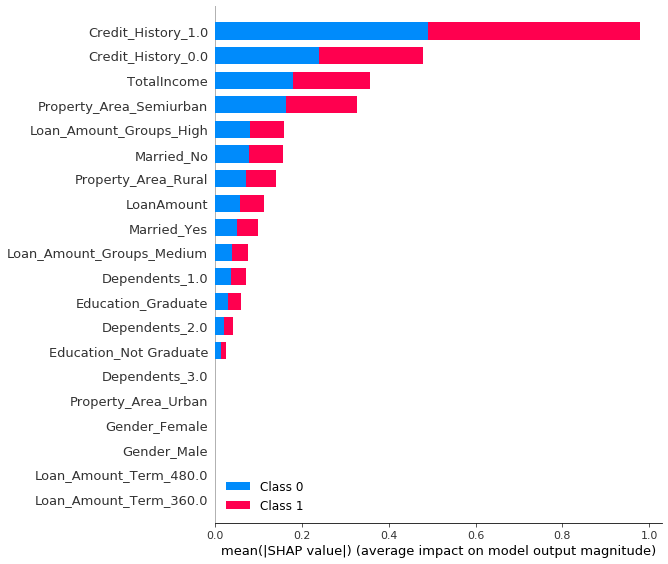

In [546]:
import shap
shapley_values = shap.TreeExplainer(lgbm_best).shap_values(X_train)
shap.summary_plot(shapley_values, X_train)

This bar graph shows depicts the shapley values of top variables affect model predictions. The length of the blue bar indicates how much the variables affect the prediction for declining loans and the red indicates that for accepting loans. This results align with our findings in the EDA portion, as we saw that the credit history of the applicants had a disproportionally large effect on the dependent variable. 

Instead of infering causality through this plot, the best use for this plot is to examine it with domain experts, the human loan application examiners for example, and see if the outputs make sense. If it is the case that these application examiners heavily consider the applicant's credit history, the property area, and his/her total income, then the model did a great job at emulating human work. An approval by domain experts may be a convincing indicator for model adoption to the decision makers.

Shapley values can also be calculated on each prediction. I will gather an instance of correct positive class prediction and correct negative prediction, and assess the shapley values associated with those decisions.

In [570]:
# Finding instances of accurate predictions for each class
y_pred = cross_val_predict(lgbm_best, X_train, label, method = "predict")

# Logic: by adding array of predictions (values of 0 or 1) with an array of actual loan status labels (values of 0 or 1) the resulting array
# will have 0 for correct prediction of negative class and 2 for correct prediction of positive class.
negative = (y_pred+label == 0)
positive = (y_pred+label == 2)

# Finding the row index of first accurate positive prediction and first accurate negative prediction
pos_pred_idx = np.where(positive)[0][0]
neg_pred_idx = np.where(negative)[0][0]

pos_pred_instance = X_train.iloc[pos_pred_idx]
neg_pred_instance = X_train.iloc[neg_pred_idx]

In [572]:
# The following code creates a function that plots shapley values of individual instances. 
### Credit Dr. Dataman, see references at the bottom. ###

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(lgbm_best)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)

In [600]:
X_train.iloc[pos_pred_idx].to_numpy().shape

(32,)

In [623]:
explainerModel = shap.TreeExplainer(lgbm_best)
shap_values_Model = explainerModel.shap_values(X_train.iloc[neg_pred_idx:neg_pred_idx + 1].head(1))

In [629]:
# Correct positive prediction
shap_values_Model = explainerModel.shap_values(X_train.iloc[pos_pred_idx:pos_pred_idx + 1].head(1))
shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


This plot shows that feature 1, feature 25, and feature 24 were the top contributors that pushed the final prediction towards a prediction towards the positive class, while feature 27, 4, and 31 were the top features that pushed the prediction towards the negative class.

In [633]:
print("Top 3 features towards positive class prediction")
print(X_train.columns[1])
print(X_train.columns[25])
print(X_train.columns[24])
print("\n")
print("Top 3 features towards negative class prediction")
print(X_train.columns[27])
print(X_train.columns[4])
print(X_train.columns[31])

Top 3 features towards positive class prediction
TotalIncome
Credit_History_1.0
Credit_History_0.0


Top 3 features towards negative class prediction
Property_Area_Semiurban
Married_No
Loan_Amount_Groups_Medium


In [637]:
# Checking the values for these features
X_train.iloc[pos_pred_idx][["TotalIncome", "Credit_History_1.0", "Credit_History_0.0",
                           "Property_Area_Semiurban", "Married_No", "Loan_Amount_Groups_Medium"]]

TotalIncome                 -0.182184
Credit_History_1.0           1.000000
Credit_History_0.0           0.000000
Property_Area_Semiurban      0.000000
Married_No                   1.000000
Loan_Amount_Groups_Medium    0.000000
Name: 0, dtype: float64

The fact that the 2 out of the top 3 contributors for the positive class prediction was Credit History column signifies just how important this feature is. Value of 0 for Semiurban and Medium loan amount group indicate that the property area not being semiurban or the loan amount group not being median has a negative effect on positive predictions.

In [628]:
shap_values_Model = explainerModel.shap_values(X_train.iloc[neg_pred_idx:neg_pred_idx + 1].head(1))
# Correct negative prediction
shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1])

In [638]:
print("Top 2 features towards positive class prediction")
print(X_train.columns[1])
print(X_train.columns[27])
print("\n")
print("Top 3 features towards negative class prediction")
print(X_train.columns[25])
print(X_train.columns[24])
print(X_train.columns[29])

Top 2 features towards positive class prediction
TotalIncome
Property_Area_Semiurban


Top 3 features towards negative class prediction
Credit_History_1.0
Credit_History_0.0
Loan_Amount_Groups_High


In [639]:
# Checking the values for these features
X_train.iloc[pos_pred_idx][["TotalIncome", "Credit_History_1.0", "Credit_History_0.0",
                           "Property_Area_Semiurban", "Loan_Amount_Groups_High"]]

TotalIncome               -0.182184
Credit_History_1.0         1.000000
Credit_History_0.0         0.000000
Property_Area_Semiurban    0.000000
Loan_Amount_Groups_High    0.000000
Name: 0, dtype: float64

Again, Credit History column occupies two out of the three top shapley values for the prediction of the instance. Talking with domain exerts about these model decisions with respect to the training data used should help the model be more transparent and interpretable.

Finally, I will quantify the uncertainty around the model. I will accomplish this through creating a confidence interval for model evaluation. By providing the range of performance the model can produce, the stakeholders will have a more robust idea of what they can expect from the model. In particular, the lower bound of the confidence interval should be helpful to know to compute risks for worst case scenarios in deplyoing the model.

I will compute the 95% confidence interval for the Light GBM model, which resulted in the higest test set accuracy out of the three original models. Before constructing the interval, we must first determine whether the accuracy of the model is normally distributed. This is because normality will determine whether the confidence interval should be parametric or non-parametric. In order to confirm this, I will be training the model and computing the accuracy score 10000 times, and plot the accuracies in a histogram to do a qualitative check of normality. If the histogram resembles a bell curve, then I will do a quantitative check of normality using D'Agostino's K-squared test to confirm normality. If not, I will proceed with a non-parametric confidence interval.

In [649]:
# Stratefied shuffling and computing 10000 accuracy scores
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(10000):
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
    for train_index, test_index in sss.split(X_train, label):
        X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_split, y_test_split = label[train_index], label[test_index]
        lgbm_best.fit(X_train_split, y_train_split)
        y_pred = lgbm_best.predict(X_test_split)
        acc = accuracy_score(y_test_split, y_pred)
        accuracies.append(acc)

In [673]:
# Computing average and standard deviation of the accuracy scores
print("mean: ", np.mean(accuracies))
print("standard deviation: ", np.std(accuracies))

mean:  0.8150233062330623
standard deviation:  0.02386844103640294


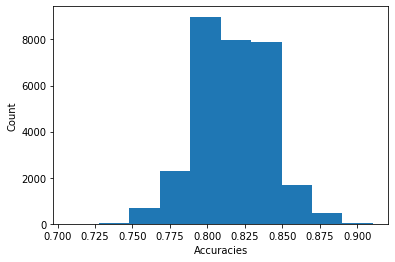

In [657]:
# Plotting the 10000 computed accuracies
plt.hist(accuracies)
plt.xlabel("Accuracies")
plt.ylabel("Count")
plt.show()

Although the distribution of accuracy scores do loosely resemble a bell curve, it is in no way perfect. Therefore, I will proceed to use D'Agostino's K-squared test for normality. This test measures normality by assessing the distribution's skew and kurtosis. The null hypythosesis is that the distribution of the data is gaussian (normal), while the alternative hypothesis is that the data is not normal. 

In [658]:
# Perform normality test
from scipy.stats import normaltest

stat, p = normaltest(accuracies)
if p <= 0.05:
    print("Reject null hypotheiss: the data is not normal.")
else:
    print("Fail to reject null hypothesis: the data is normal")

Fail to reject null hypothesis: the data is normal


Now that the distribution of the performance metric (accuracy) is identified to be normal, I will construct a parametric 95% confidence interval for accuracy.

In [663]:
# Computing accuracy with one stratified split of the training data.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X_train, label):
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = label[train_index], label[test_index]
    lgbm_best.fit(X_train_split, y_train_split)
    y_pred = lgbm_best.predict(X_test_split)
    acc = accuracy_score(y_test_split, y_pred)
    
# Construct 95% confidence interval: accuracy +- 1.96 * sqrt((accuracy*(1-accuracy))/n)
n = len(y_test_split)
lower_bound = acc -(1.96* np.sqrt((acc*(1-acc))/n))
upper_bound = acc +(1.96* np.sqrt((acc*(1-acc))/n))
confidence_interval = (lower_bound), (upper_bound)

In [669]:
print(confidence_interval)

(0.7073375400426843, 0.8536380697134133)


According to the analysis, the model's true accuracy should be between about 70.73% and 85.36% with 95% confidence. 

<br>
This concludes my analysis for this loan prediction dataset. If I were to share my findings with the stakeholder, I will present them with the average of the accuracy scores, as well as their standard deviation to technical stakeholders who can benefit from knowing this information. Then, I will present the accuracy confidence interval of (0.7073, 0.8536) to give the stakeholders a broader understanding of the true model performance. If the risk they may incur by adoping the model with the lower bound accuracy score is still less than the potential gains, then it may be a convincing metric for decision makers. Finally, I will present to the stakeholders the model interpretation via shapley values to confirm that the model's decisions aren't too unexpected, and to lower the friction they may feel for adopting a machine learning model for automation.

# Conclusion

This project was a classification project for loan prediction. After EDA to understand the data, I explored usage of different features and different models to shortlist the top three performing models, which were Logistic Regression, Random Forest, and Light GBM. I hyperparameter tuned all three, and found the Light GBM model to have the best test set performance. Though I have omitted the process because it went out of the scope of the project, I ensembled a soft-voting classifier with the Logistic Regression model and the Light GBM model to score top 10% on the leaderboard with this competition. Then, I explored threshold optimization by assignning expected profits/losses to different prediction outcomes and computing the profit-maximizing prediction threshold. Finally, I conducted supplemental analysis to present the model to stakeholders. Namely, I made the model more interpretable by calculating its shapley values, and I computed the uncertainty around model performance.

One thing to note is that the confidence interval calculation had some data leakage. This is because it was computed using only the training data, which was used in the EDA and preprocessing. Ideally, the interval calculation should have been done using the test set. However, there are no true labels provided for the test set as this is a data science competition dataset, and therfore calculations couldn't have been made with the test set. If I were to further give a more robust quantification of uncertainty, I will also quantify the uncertainty resulting from using MissForest for imputation (as it uses a Random Forest algorithm), as well as uncertainty from hyperparameter optimization by running RandomizedSearchCV numerous times.

For future work, I would like to work on more complex datasets with more features to work with and with a labeled test set. I would like to try out different model interpretation methods, such as LIME and InterpretML, and do a more robust post-modeling analysis. Using the analysis, I would like to construct a dashboard and a deck to present to stakeholders to ease their process of model adoption. Finally, I would like to deploy that model on a web server. Thank you for taking an interest in my project.

# References

Dataset and competition: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#ProblemStatement
<br>Dr. Dataman for shapley values: https://towardsdatascience.com/explain-your-model-with-the-shap-values-